In [1]:
# TODO: signals based on lows
############
# https://stackoverflow.com/questions/69800749/using-python-to-get-holdings-and-allocation-of-etfs
# conda env create -f environment.yml
# conda install -f environment.yml
# conda update -n base conda
# conda env update --file environment.yml --prune
# jupyter nbconvert --clear-output --inplace *.ipynb
TEST = ""
def set_test(tix: str):
    global TEST
    TEST = TEST or []
    if type(TEST) == str:
        TEST = TEST.split(" ")
    if type(tix) == str:
        tix = tix.split(' ')
    return ' '.join(sorted([r for r in set(TEST + tix) if bool(r)]))

BENCH = 'VOO CRPT ^VIX '# KBWP PAVE IGM VGT QMOM URNM AMZA PKB=XHB SLX
BROKERAGE = 'AIRR CLSE CRPT HTUS IAI IGM KBWP KCE MGK PAVE PKB PSP RSHO SLX SPSM UTES VCR VDE VFH VGT VHT VIG VOO VOT VUG VYM XBI XHB XMMO XSMO'
ROTH = 'AMZA CRPT IGM PAVE PKB QQQ SCHG SPYG URNM VGT XHB' # Roth 2024.03.14. 04.01 -IVW VOO MGK VTI IUSG VUG

# BASE = 'VOT VOO VTI FLMVX FXAIX'
# CONSTRUCTION = 'AIRR PKB XHB ITB'
# GROWTH = 'MGK VGT VUG QQQ IVW SCHG SPYG IUSG FCNKX JDMNX MITJX VIGIX'
# DIV = 'VYM VIG'
# ENERGY = 'AMZA URNM VDE'
# INSURANCE = 'KBWP'
# SECTORS = 'VOX VCR VDC VFH VHT VIS VAW VPU RSHO PRN'
# INTERNATIONALS = 'VEU VSS VEA VWO VGK VPL VNQI VXUS VT'
# CRYPTO = 'CRPT'# DAPP BITQ BKCH SATO WGMI IBLC # BITX (2023-06-27) GBTC IBIT (2024-1-11)
# INFRA = 'PAVE'# IGF IFRA NFRA EMIF RBLD
# AI = 'IGM IYW FTEC FDN'

# TEST = BENCH + "BTC-USD ETH-USD"
# TEST = BENCH + 'CLSE IAI KCE PSP XMMO XSMO UTES HTUS XBI XHB SPSM' # HRTS CBLS USE GCAD SLX VDE
TEST = set_test(BENCH)
TEST = set_test(BROKERAGE)
TEST = set_test(ROTH)
TEST = set_test("VFMO FPX BETZ") #AMPL

print("https://www.etfdb.com")
print("https://www.etfrc.com/funds/overlap.php")
print(TEST)
# TEST = set_test("BTC-USD ETH-USD")
# TEST = "AIRR CLSE CRPT HTUS IAI IGM KCE KBWP MGK PAVE PKB PSP RSHO SLX SPSM VCR VDE VFH VGT VHT VIG VOO VOT VUG VYM XBI XHB XMMO XSMO ^VIX"
start = '2020-11-03'

https://www.etfdb.com
https://www.etfrc.com/funds/overlap.php
AIRR AMZA BETZ CLSE CRPT FPX HTUS IAI IGM KBWP KCE MGK PAVE PKB PSP QQQ RSHO SCHG SLX SPSM SPYG URNM UTES VCR VDE VFH VFMO VGT VHT VIG VOO VOT VUG VYM XBI XHB XMMO XSMO ^VIX


## Data

In [2]:
# Import libraries and pull data
import datetime
import warnings
import re
import json
import textwrap
import numpy as np
import pandas as pd
# import pandas_ta as ta
import yfinance as yf
#import quantstats as qs
import seaborn as sns
import cufflinks as cf
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import widgets, interact, interactive
from scipy import stats
#from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from keras.models import Sequential
#from keras.layers import Dense, LSTM, Activation
from IPython.display import display, clear_output, HTML
from yahooquery import Ticker, Screener
from pyvis import network as net
import networkx as nx
import matplotlib.pyplot as plt
plt.style.use('dark_background')

cf.go_offline()
pio.renderers.default = 'iframe'
warnings.filterwarnings("ignore", category=FutureWarning, module="yfinance")
warnings.filterwarnings("ignore", category=FutureWarning, module="cufflinks")
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", "warn_singular")
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
template = 'plotly_dark'
pd.options.display.float_format = "{:,.2f}".format

# EPOCH=64
# EPOCH=32
NOP = 20000 # Number of random portfolio sets
risk_free_return = .05
ichimoku_window = 26
rwindow = 6 # How many trading days to aggregate MACD/ RSI for
cutoff = 16 # % of samples falling below that satisfy criteria for MACD/ RSI
cofactor = 6 # fraction of ^ to generate buy/sell signal
model = 'Sharpe'
categories = {
    # "ai": AI,
    # "base": BASE,
    # "construction": CONSTRUCTION,
    # "crypto": CRYPTO,
    # "div": DIV,
    # "energy": ENERGY,
    # "growth": GROWTH,
    # "infra": INFRA,
    # "insurance": INSURANCE,
    # "internationals": INTERNATIONALS,
    # "sectors": SECTORS,
}
symbol_map={'triangle-up':'triangle-up', 'triangle-down':'triangle-down', 'square': 'square', 'circle':'circle'}

In [3]:
def alpha_arbitrage(v, msk):
    df = pd.DataFrame()
    # drop over 1 months
    # drop over 1 months vs VOO
    # rise over next X months
    # rise over next X months vs VOO
    df['discount.beta'] = (edf[v]['Adj Close'].pct_change(22, fill_method=None) - idx['Adj Close','VOO'].pct_change(22, fill_method=None))*100
    df['ft.prc'] = edf[v]['Adj Close'].pct_change(-22, fill_method=None) * 100
    df['ft.alpha'] = (edf[v]['Adj Close'].pct_change(-22, fill_method=None) - idx['Adj Close','VOO'].pct_change(-22, fill_method=None))*100
    return {v: {'ft.rtn': round(float(df[msk]['ft.prc'].describe()['mean']), 2), 'outperform': round(float(df[msk]['ft.alpha'].describe()['mean']), 2), 'count': int(df[msk]['ft.alpha'].describe()['count'])}}

def rsi_target(df1, prc=25):
    df = df1.copy()
    pt={v:0 for v in df['Adj Close'].columns}
    for _ in range(100):
        df.loc[df['Adj Close'].index[-1], 'Adj Close'] = df.iloc[-1].loc['Adj Close'].values * .99
        cv = calculate_rsi(df).tail(1)
        for v in cv:
            if bool(pt[v]):
                continue
            tv = df.iloc[-1]['Adj Close', v].round(2)
            pt[v] = pt[v] if cv[v].iloc[-1] > prc else float(tv)
    return pt

def compare_values_ichi(row):
    if row['Close'] > max([row['senkou_span_a'], row['senkou_span_b']]):
        if row['senkou_span_a'] > row['senkou_span_b']:
            return 'top left'
        elif row['senkou_span_a'] < row['senkou_span_b']:
            return 'top right'
        return 'top center'
    elif row['Close'] < min([row['senkou_span_a'], row['senkou_span_b']]):
        if row['senkou_span_a'] < row['senkou_span_b']:
            return 'bottom left'
        elif row['senkou_span_a'] > row['senkou_span_b']:
            return 'bottom right'
        return 'bottom center'
    else:
        return 'middle center'

def calc_positions_ichimoku(d):
    global idx
    columns = d['Low'].columns
    # Adding signals for buy/ sell
    condition = np.where(
        (d['tenkan_sen'] > d['kijun_sen']) &
        (d['Close'] > d['tenkan_sen']) &
        (
            ((d['Close'] > d['senkou_span_a']) & (d['Close'] > d['senkou_span_b'])) |
            ((d['Close'] < d['senkou_span_a']) & (d['Close'] < d['senkou_span_b']))
        ), 1, 0
    )
    sgn = pd.DataFrame(condition, columns=columns, index=d.index)
    sgn.columns = pd.MultiIndex.from_product([['signal_ichimoku'], columns])
    pos = sgn.diff().fillna(0)
    pos.columns = pd.MultiIndex.from_product([['position_ichimoku'], columns])
    idx.drop(columns='signal_ichimoku', inplace=True, errors='ignore')
    idx.drop(columns='position_ichimoku', inplace=True, errors='ignore')
    idx = idx.join(pos)
    idx = idx.join(sgn)

def calc_positions_rsi(d):
    global idx
    columns = d['Low'].columns
    # Adding signals for buy/ sell
    indicator='RSI'
    period=42
    sgn = pd.DataFrame(np.where(d[indicator].rolling(window=period).mean() - idx[indicator] - .3 < 0, 0, 1), columns=columns, index=d.index)
    sgn.columns = pd.MultiIndex.from_product([['signal_rsi'], columns])
    pos = sgn.diff().fillna(0)
    pos.columns = pd.MultiIndex.from_product([['position_rsi'], columns])
    idx.drop(columns='signal_rsi', inplace=True, errors='ignore')
    idx.drop(columns='position_rsi', inplace=True, errors='ignore')
    idx = idx.join(pos)
    idx = idx.join(sgn)
    
def calc_positions_ema(d):
    global idx
    columns = d['Low'].columns
    # Adding signals for buy/ sell
    sgn = pd.DataFrame(np.where(d['EMAW'] > d['EMAM'], 1, 0), columns=columns, index=d.index)
    sgn.columns = pd.MultiIndex.from_product([['signal_ema'], columns])
    pos = sgn.diff().fillna(0)
    pos.columns = pd.MultiIndex.from_product([['position_ema'], columns])
    idx.drop(columns='signal_ema', inplace=True, errors='ignore')
    idx.drop(columns='position_ema', inplace=True, errors='ignore')
    idx = idx.join(pos)
    idx = idx.join(sgn)

def price_bands(period = 42, multiplier = 1.8): # Calculate price bands
    global idx
    
    columns = idx['Low'].columns
    
    std = idx['Adj Close'].rolling(window=period).std()
    std.columns = pd.MultiIndex.from_product([['STD'], columns])
    idx = idx.join(std)
    
    ma = idx['Adj Close'].rolling(window=period).mean()
    ma.columns = pd.MultiIndex.from_product([['MA'], columns])
    idx = idx.join(ma)
    
    uband = idx['MA'] + multiplier * idx['STD']
    uband.columns = pd.MultiIndex.from_product([['UBAND'], columns])
    idx = idx.join(uband)
    
    lband = idx['MA'] - multiplier * idx['STD']
    lband.columns = pd.MultiIndex.from_product([['LBAND'], columns])
    idx = idx.join(lband)

    emaw = idx['Adj Close'].ewm(span=5, adjust=False).mean()
    emaw.columns = pd.MultiIndex.from_product([['EMAW'], columns])
    idx = idx.join(emaw)
    
    emam = idx['Adj Close'].ewm(span=21, adjust=False).mean()
    emam.columns = pd.MultiIndex.from_product([['EMAM'], columns])
    idx = idx.join(emam)
    
    # Moving Average Convergence Divergence
    mdl = idx['EMAM'] - idx['EMAW']
    sgl = mdl.ewm(span=16, adjust=False).mean()
    mdh = sgl - mdl
    mdh.columns = pd.MultiIndex.from_product([['MACD'], columns])
    idx = idx.join(mdh)

    # Relative Strength Index
    rsi = calculate_rsi(idx)/25-2
    rsi.columns = pd.MultiIndex.from_product([['RSI'], columns])
    idx = idx.join(rsi)
    
    idx = calc_ichimoku(idx)
    calc_positions_ichimoku(idx)
    calc_positions_ema(idx)
    calc_positions_rsi(idx)

    summary['UBAND'] = idx['UBAND'].iloc[-1]
    summary['Adj Close'] = idx['Adj Close'].iloc[-1]
    summary['LBAND'] = idx['LBAND'].iloc[-1]

    rsi_prc = idx.rolling(rwindow).mean()['RSI'].rank(pct=True) * 100
    macd_prc = idx.rolling(rwindow).mean()['MACD'].rank(pct=True) * 100
    if '^VIX' in macd_prc.columns:
        macd_prc['^VIX'] = 100 - macd_prc['^VIX']
        rsi_prc['^VIX'] = 100 - rsi_prc['^VIX']
    rsi_prc.columns = pd.MultiIndex.from_product([['RSI_prc'], columns])
    idx = idx.join(rsi_prc)
    macd_prc.columns = pd.MultiIndex.from_product([['MACD_prc'], columns])
    idx = idx.join(macd_prc)
    for indicator in ['MACD_prc', 'RSI_prc']:
        summary[indicator] = idx[indicator].iloc[-1]
        
    columns = idx['Low'].columns
    conditions = [
        idx['tenkan_sen'] > idx['kijun_sen'],
        idx['tenkan_sen'] == idx['kijun_sen'],
        idx['tenkan_sen'] < idx['kijun_sen']
    ]
    choices = ['triangle-up', 'square', 'triangle-down']
    shape = np.select(conditions, choices, default='circle')
    shape = pd.DataFrame(np.select(conditions, choices, default='circle'))
    shape.columns = pd.MultiIndex.from_product([['symbol'], columns])
    shape.index=idx.index
    idx = idx.join(shape)
    
    trend = (
        (idx['Close'] > idx['tenkan_sen']) & (idx['tenkan_sen'] > idx['kijun_sen'])
    )|(
        (idx['Close'] < idx['tenkan_sen']) & (idx['tenkan_sen'] < idx['kijun_sen'])
    )
    trend = (trend).astype(int)/2+.5
    trend.columns = pd.MultiIndex.from_product([['trend'], columns])
    trend.index=idx.index
    idx = idx.join(trend)
    
def calculate_rsi(data, window=10):
    delta = data['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rsi = 100 - (100 / (gain / loss + 1))
    return rsi

def fillcol(d):
    np.where(d['senkou_span_a'] > d['senkou_span_b'], 'green', 'red')

def calc_ichimoku(d, tenkan_window=9, kijun_window=ichimoku_window, senkou_span_b_window=ichimoku_window*2, cloud_displacement=ichimoku_window, chikou_shift=ichimoku_window):
    last_date = d['Low'].dropna().index[-1]
    if type(d['Low']) == pd.core.frame.DataFrame:
        columns = d['Low'].columns
        # Tenkan-sen (Conversion Line): (9-period high + 9-period low)/2))
        nine_period_high = d['High'].rolling(window= tenkan_window).max()
        nine_period_low = d['Low'].rolling(window= tenkan_window).min()
        tenkan_sen = (nine_period_high + nine_period_low) /2
        tenkan_sen.columns = pd.MultiIndex.from_product([['tenkan_sen'], columns])
        d = d.join(tenkan_sen)

        # Kijun-sen (Base Line): (26-period high + 26-period low)/2))
        period26_high = d['High'].rolling(window=kijun_window).max()
        period26_low = d['Low'].rolling(window=kijun_window).min()
        kijun_sen = (period26_high + period26_low) / 2
        kijun_sen.columns = pd.MultiIndex.from_product([['kijun_sen'], columns])
        d = d.join(kijun_sen)

        # Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
        senkou_span_a = ((d['tenkan_sen'] + d['kijun_sen']) / 2).shift(cloud_displacement)
        senkou_span_a.columns = pd.MultiIndex.from_product([['senkou_span_a'], columns])
        d = d.join(senkou_span_a)

        # Senkou Span B (Leading Span B): (52-period high + 52-period low)/2))
        period52_high = d['High'].rolling(window=senkou_span_b_window).max()
        period52_low = d['Low'].rolling(window=senkou_span_b_window).min()
        senkou_span_b = ((period52_high + period52_low) / 2).shift(cloud_displacement)
        senkou_span_b.columns = pd.MultiIndex.from_product([['senkou_span_b'], columns])
        d = d.join(senkou_span_b)

        # The most current closing price plotted 26 time periods behind (optional)
        chikou_span = d['Close'].shift(-chikou_shift)
        chikou_span.columns = pd.MultiIndex.from_product([['chikou_span'], columns])
        d = d.join(chikou_span)

    else:
        # Step 2: Create a new date range for the next 26 business days
        new_dates = pd.date_range(start=last_date+pd.Timedelta(days=1), periods=kijun_window, freq=pd.offsets.BDay())
        # Step 3: Convert the DatetimeIndex to a DateIndex (i.e., remove the time part)
        new_dates = new_dates.date  # This will convert the index to date type
        # Step 4: Create a new dataframe with the new business dates (as date type index)
        new_data = pd.DataFrame(index=new_dates)
        # Step 5: Append the new rows to the original dataframe
        d = pd.concat([d, new_data])

        # Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
        d['senkou_span_a'] = ((d['tenkan_sen'] + d['kijun_sen']) / 2).shift(cloud_displacement)

        # Senkou Span B (Leading Span B): (52-period high + 52-period low)/2))
        period52_high = d['High'].rolling(window=senkou_span_b_window).max()
        period52_low = d['Low'].rolling(window=senkou_span_b_window).min()
        d['senkou_span_b'] = ((period52_high + period52_low) / 2).shift(cloud_displacement)

        # The most current closing price plotted 26 time periods behind (optional)
        d['chikou_span'] = d['Close'].shift(-chikou_shift)
    return d
    
def plot2_ichimoku(d, ticker_name='', INCREASING_COLOR='green', DECREASING_COLOR='red', show_rangeslider=False):
    fig = go.Figure(data=[go.Candlestick(x=d.index, open=d.Open, high=d.High, low=d.Low, close=d.Close,
         increasing_line_color=INCREASING_COLOR, decreasing_line_color=DECREASING_COLOR, showlegend=False)])
    kw = {'x': d.index, 'type': 'scatter', 'mode':'lines', 'showlegend': False}#'visible':'legendonly'}

    # Add TenkenSen to plot
    fig.add_trace(go.Scatter(y=d['tenkan_sen'], name='tenkan_sen', line=dict(color='#33BDFF', width=1), **kw))
    # Add kijun_sen to plot
    fig.add_trace(go.Scatter(y=d['kijun_sen'], name='kijun_sen', line=dict(color='#F1F316', width=1), **kw))

    kw = {'x': d.index, 'type': 'scatter', 'mode':'lines', 'showlegend': False}
    # Add senkou_span_a to plot
    fig.add_trace(go.Scatter(y=np.where(d['senkou_span_a'] > d['senkou_span_b'], d['senkou_span_a'], d['senkou_span_b']), name='senkou_span_max', line=dict(color='#228B22', width=0), **kw))
    fig.add_trace(go.Scatter(
        y=d['senkou_span_b'], 
        fill='tonexty',
        fillcolor='rgba(0, 128, 0, 0.25)',
        line=dict(color='rgba(0, 128, 0, 0.1)'),
        name='senkou_span_a above',
        **kw
    ))

    fig.add_trace(go.Scatter(y=np.where(d['senkou_span_b'] > d['senkou_span_a'], d['senkou_span_b'], d['senkou_span_a']), name='senkou_span_min', line=dict(color='#228B22', width=0), **kw))
    fig.add_trace(go.Scatter(
        y=d['senkou_span_a'], 
        fill='tonexty',
        fillcolor='rgba(128, 0, 0, 0.25)',
        line=dict(color='rgba(128, 0, 0, 0.1)'),
        name='senkou_span_b above',
        **kw
    ))

    # Add chikou_span to plot
    fig.add_trace(go.Scatter(y=d['chikou_span'], name='chikou_span', line=dict(color='#D105F5', width=1), **kw))
    fig.update_layout(xaxis_rangeslider_visible=show_rangeslider)

    fig.update_layout(
        # title='Ichimoku',
        yaxis_title=f'{ticker_name} Price',
        xaxis_title='Date',
        legend=dict(orientation='h', y=0.1, x=0.1, yanchor='top'),
        margin=dict(t=40, b=40, r=40, l=40),
        yaxis=dict(type='log'),
        template=template,
    )
    return fig #.show()

def ann_risk_return(df):
    rdf = df.agg(["mean", "std"]).T
    rdf.columns = ["Return", "Risk"]
    rdf.Return = (df.iloc[-1] / df.iloc[0]) ** (1/(((df.index[-1]-df.index[0]).days)/365)) - 1
    rdf.Risk = rdf.Risk * np.sqrt(252)
    return rdf

def get_sortino(df):
    returns = df.pct_change(1).dropna()
    downside_returns = returns[returns < 0]
    downside_std = np.std(downside_returns, axis=0)
    sortino_ratio = returns.mean() / downside_std
    return sortino_ratio

def get_parent(ticker):
    for parent in categories:
        if ticker in (categories[parent]).split():
            return parent
    return summary.loc[ticker,'category']

def h_max(s):
    try:
        is_max = s.astype('float') == s.max()
        return ['color: green' if cell else '' for cell in is_max]
    except:
        return ['' for cell in s]

def h_min(s):
    try:
        is_min= s.astype('float') == s.min()
        return ['color: blue' if cell else '' for cell in is_min]
    except:
        return ['' for cell in s]

def h_bull(s):
    try:
        is_bs = s.astype('str').str.contains('ullish|Buy', regex=True) & ~s.astype('str').str.contains('earish|Sell', regex=True) & ~s.astype('str').str.contains('Weak') & ~s.astype('str').str.contains(' one ')
        return ['color: green' if cell else '' for cell in is_bs]
    except:
        return ['' for cell in s]

def h_bear(s):
    try:
        is_bs = s.astype('str').str.contains('earish|Sell', regex=True) & ~s.astype('str').str.contains('ullish|Buy', regex=True) & ~s.astype('str').str.contains('Weak') & ~s.astype('str').str.contains(' one ')
        return ['color: red' if cell else '' for cell in is_bs]
    except:
        return ['' for cell in s]
    
def de_macd(fund):
    df = pd.DataFrame(idx['Adj Close'][fund].copy())
    df['Adj Close'] = df[fund]
    step = df.loc[df.index[-1], 'Adj Close'] * .002
    if (idx['MACD_prc'][fund].rank(pct=True)*100 < cutoff/cofactor).iloc[-1]:
        return df.loc[df.index[-1], 'Adj Close']
    for i in range(100):
        df.loc[df.index[-1], 'Adj Close'] -= step
        df['emaw'] = df['Adj Close'].ewm(span=5, adjust=False).mean()
        df['emam'] = df['Adj Close'].ewm(span=21, adjust=False).mean()
        df['mdl'] = df['emam'] - df['emaw']
        df['sgl'] = df['mdl'].ewm(span=16, adjust=False).mean()
        df['mdh'] = df['sgl'] - df['mdl']
        if df['mdh'].rank(pct=True).iloc[-1]*100 < cutoff/ cofactor:
            return df.loc[df.index[-1], 'Adj Close']
    return

def de_rsi(fund, window=10):
    df = pd.DataFrame(idx['Adj Close'][fund].copy())
    df['Adj Close'] = df[fund]
    step = df.loc[df.index[-1], 'Adj Close'] * .002
    if (idx['RSI_prc'][fund].rank(pct=True)*100 < cutoff/cofactor).iloc[-1]:
        pass #return df.loc[df.index[-1], 'Adj Close']
    for i in range(100):
        df.loc[df.index[-1], 'Adj Close'] -= step
        delta = df['Adj Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rsi = 100 - (100 / (gain / loss + 1))
        if (rsi.rank(pct=True)*100 ).iloc[-1] < cutoff/ cofactor:
            return df.loc[df.index[-1], 'Adj Close']
    return

def annualize(fund, days, x=-1):
    idx.index = idx_index
    yfraction = (((pd.to_datetime(idx['Adj Close'][fund].index[x]).date()-pd.to_datetime(idx['Adj Close'][fund].index[x-days-1]).date()).days)/365)
    rf = (idx['Adj Close'][fund].iloc[x] / idx['Adj Close'][fund].iloc[x-days-1]) ** (1/yfraction) - 1
    rv = (idx['Adj Close']['VOO'].iloc[x] / idx['Adj Close']['VOO'].iloc[x-days-1]) ** (1/yfraction) - 1
    return rf - rv

In [4]:
tix = " ".join(sorted(set(TEST.split())))
for _ in range(3):
    kw = {'start': start, 'auto_adjust': False}
    end = datetime.datetime.now().strftime("%Y-%m-%d")
    # TODO: change theme if dropped data
    
    # kw['end'] = '2025-01-17'
    idx = yf.download(tix, **kw)
    idx.index = idx.index.date
    if idx['Adj Close'].index[0] != idx['Adj Close'].dropna().index[0]:
        start = idx['Adj Close'].dropna().index[0]
        print(f"\nCommon start: {start}")
        display(idx['Adj Close'][:start].fillna(''))
        idx = idx.loc[start:]
    adj_prices = idx['Adj Close'].copy()
    if any(adj_prices.iloc[-1].isna()):
        print("Missing data from today!!!")
        columns_with_na_in_last_row = adj_prices.columns[adj_prices.isna().iloc[-1]].tolist()
        if adj_prices.loc[:,~adj_prices.iloc[-1].isna()].columns.size == 1 and adj_prices.loc[:,~adj_prices.iloc[-1].isna()].columns[0] == '^VIX':
            print("One ticker returned for VIX!!!")
            columns_with_na_in_last_row = ['^VIX']
            tix = adj_prices.columns[adj_prices.isna().iloc[-1]].tolist()
            continue
        print(f"Drop {columns_with_na_in_last_row}" + 10*"\n")
        tix = adj_prices.columns[~adj_prices.isna().iloc[-1]].tolist()
    else:
        break
display(adj_prices.tail())
display(100*adj_prices.pct_change(1, fill_method=None).tail())
prices = idx['Adj Close'].div(idx['Adj Close'].iloc[0]).mul(100)
ret = prices.pct_change().dropna()
summary = pd.DataFrame(index=idx['Adj Close'].columns)
price_bands() # Calculate price bands

[*********************100%***********************]  39 of 39 completed


Common start: 2023-05-11


Ticker,AIRR,AMZA,BETZ,CLSE,CRPT,FPX,HTUS,IAI,IGM,KBWP,...,VIG,VOO,VOT,VUG,VYM,XBI,XHB,XMMO,XSMO,^VIX
2020-11-03,27.79,9.48,19.86,,,96.76,19.03,59.56,50.28,54.68,...,119.61,288.65,179.39,219.65,71.78,115.46,52.91,66.61,40.28,35.55
2020-11-04,27.05,9.54,20.34,,,101.49,19.36,59.62,52.56,53.78,...,121.10,295.15,184.62,228.58,71.59,122.56,54.33,68.43,40.66,29.57
2020-11-05,27.97,9.85,21.13,,,103.86,19.61,60.52,54.03,54.84,...,123.09,300.93,188.18,233.82,72.76,122.45,55.14,70.65,41.87,27.58
2020-11-06,27.67,9.35,21.17,,,106.20,19.62,60.04,54.20,55.01,...,123.35,300.89,189.50,234.36,72.62,119.49,54.65,70.77,41.50,24.86
2020-11-09,29.34,10.60,21.11,,,101.36,20.04,63.28,53.27,58.19,...,124.78,304.64,186.76,230.76,75.46,119.99,51.57,67.55,40.65,25.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-05,46.25,26.65,17.09,14.64,5.07,80.60,25.78,85.29,55.81,80.89,...,150.49,368.37,186.24,249.32,98.40,85.24,69.67,73.51,43.90,17.19
2023-05-08,46.03,26.59,17.08,14.67,4.85,81.64,25.91,84.97,56.11,81.57,...,150.28,368.57,186.38,250.03,98.33,84.86,70.08,73.37,43.88,16.98
2023-05-09,46.45,26.80,17.14,14.62,4.94,81.56,25.78,84.85,55.78,81.89,...,149.74,366.98,185.86,248.90,97.92,85.77,70.21,73.19,43.64,17.71
2023-05-10,46.40,26.90,17.12,14.62,5.15,81.41,25.82,84.74,56.58,81.36,...,149.92,368.58,187.44,251.50,97.71,87.13,70.07,73.30,43.80,16.94


Missing data from today!!!
One ticker returned for VIX!!!


[*********************100%***********************]  38 of 38 completed


Ticker,AIRR,AMZA,BETZ,CLSE,CRPT,FPX,HTUS,IAI,IGM,KBWP,...,VHT,VIG,VOO,VOT,VUG,VYM,XBI,XHB,XMMO,XSMO
2025-03-31,68.21,47.51,18.80,21.61,12.23,111.74,36.43,140.11,90.67,124.59,...,264.73,193.99,513.91,244.64,370.82,128.96,81.10,96.90,113.76,62.75
2025-04-01,68.86,47.54,18.82,21.76,12.76,113.12,36.50,140.46,91.57,125.04,...,259.93,193.65,515.80,246.23,374.17,128.68,78.16,97.20,115.05,62.68
2025-04-02,70.52,47.77,19.24,21.84,13.28,115.60,36.62,142.73,92.21,125.01,...,261.92,194.80,518.91,248.90,377.29,129.43,80.59,98.82,116.90,63.70
2025-04-03,65.29,45.11,18.58,21.10,12.23,107.82,34.85,133.81,85.77,124.13,...,259.09,187.76,494.16,235.35,355.58,124.11,78.14,91.82,110.18,59.38
2025-04-04,62.58,40.53,17.51,20.12,11.88,99.20,32.00,123.93,80.57,114.37,...,244.93,177.07,465.52,220.56,334.02,117.03,73.66,92.87,103.22,56.77


Ticker,AIRR,AMZA,BETZ,CLSE,CRPT,FPX,HTUS,IAI,IGM,KBWP,...,VHT,VIG,VOO,VOT,VUG,VYM,XBI,XHB,XMMO,XSMO
2025-03-31,-0.09,-0.27,-1.41,0.84,-3.09,-0.37,0.50,0.50,-0.15,1.03,...,0.70,1.07,0.61,0.22,0.11,1.11,-3.91,0.83,0.57,3.09
2025-04-01,0.95,0.06,0.12,0.69,4.33,1.24,0.19,0.25,0.99,0.36,...,-1.81,-0.18,0.37,0.65,0.90,-0.22,-3.63,0.31,1.13,-0.11
2025-04-02,2.41,0.48,2.23,0.37,4.08,2.19,0.34,1.62,0.70,-0.02,...,0.77,0.59,0.60,1.08,0.83,0.58,3.11,1.67,1.61,1.63
2025-04-03,-7.42,-5.57,-3.41,-3.39,-7.91,-6.73,-4.84,-6.25,-6.98,-0.70,...,-1.08,-3.61,-4.77,-5.44,-5.75,-4.11,-3.04,-7.08,-5.75,-6.78
2025-04-04,-4.15,-10.15,-5.77,-4.64,-2.86,-7.99,-8.19,-7.38,-6.06,-7.86,...,-5.47,-5.69,-5.80,-6.28,-6.06,-5.70,-5.73,1.14,-6.32,-4.40


In [5]:
dev = pd.DataFrame()
dev['pct_change'] = idx['Adj Close'].pct_change().iloc[-1]*100
dev['x_std'] = (idx['Adj Close'].pct_change()/idx['Adj Close'].pct_change().std()).iloc[-1]
for i in range(1,5):
    dev[f"std{i}"] = idx['Adj Close'].iloc[-1] - i * idx['Adj Close'].std()**.5
dev

,pct_change,x_std,std1,std2,std3,std4
Ticker,,,,,,
AIRR,-4.15,-2.69,59.27,55.96,52.64,49.33
AMZA,-10.15,-7.43,38.14,35.75,33.35,30.96
BETZ,-5.77,-4.23,16.33,15.15,13.97,12.80
CLSE,-4.64,-5.35,18.41,16.69,14.98,13.26
CRPT,-2.86,-0.59,9.73,7.58,5.44,3.29
FPX,-7.99,-4.97,95.34,91.48,87.63,83.77
HTUS,-8.19,-8.11,29.90,27.81,25.71,23.62
IAI,-7.38,-6.15,119.27,114.62,109.96,105.30
IGM,-6.06,-4.28,76.75,72.92,69.10,65.27


## Radar

In [6]:
indicators = summary[['Adj Close', 'LBAND']].copy()
demacd = [de_macd(fund) for fund in summary.index]
dersi = [de_rsi(fund) for fund in summary.index]
indicators['macd'] = demacd
indicators['rsi'] = dersi
indicators.drop(['^VIX'], inplace=True, errors='ignore')
fig = px.imshow((indicators['Adj Close'].T-indicators.T)/indicators.T.std(), template=template, title='Buy Indicators', color_continuous_scale=["blue", 'white', "red"], range_color=[-3, 3], color_continuous_midpoint=0, text_auto=False)
text_abs = [[indicators[c].values] for c in indicators.columns]
text_prc = [[(indicators[c].values/ indicators['Adj Close'].values)*100-100 ] for c in indicators.columns]
custom_text=[]
for row1, row2 in zip(text_abs, text_prc):
    for j in range(len(row2)):
        custom_text.append(["{:.2f}<br>{:.1f}%".format(row1[j][k], row2[j][k]) for k in range(len(row2[j]))])

fig.update_traces(text=custom_text, texttemplate="%{text}")
fig.update_layout(xaxis=dict(side="top"), font=dict(size=12))
fig.show()

In [7]:
x=-0
if bool(x):
    print((f"!!! NOT USING default today's date!!!"+"\n")*5)

In [8]:
if type(x) == str:
    x=0
x-=1 # Use previous day's data
idx_index = idx.index
idx.index = idx.index.astype(str)
trend = (
    (idx['Close'] > idx['tenkan_sen']) & (idx['tenkan_sen'] > idx['kijun_sen'])
)|(
    (idx['Close'] < idx['tenkan_sen']) & (idx['tenkan_sen'] < idx['kijun_sen'])
)
cloudposition = [idx.swaplevel(1,0, axis=1)[v].apply(compare_values_ichi, axis=1).iloc[x] for v in idx['Low'].columns]
x_idx = idx['MACD_prc'].iloc[x] + np.random.uniform(-0.1, 0.1, size=len(idx['Close'].columns))
y_idx = idx['RSI_prc'].iloc[x] + np.random.uniform(-0.1, 0.1, size=len(idx['Close'].columns))
g = px.scatter(
    idx.iloc[x],
    text=[i.upper() if v else i.lower() for i, v in idx['signal_ichimoku'].iloc[x].items()],
    x=x_idx,
    y=y_idx,
    hover_name=[i.upper() if v else i.lower() for i, v in idx['signal_ichimoku'].iloc[x].items()],
    hover_data=[idx.iloc[x]['Adj Close'], rsi_target(idx[:x]).values()],
    color=idx['Adj Close'].pct_change().iloc[x].values*100, color_continuous_scale='RdYlGn', color_continuous_midpoint=0.0,
    title=f"RSI vs MACD Rankings as of {idx.index[x]}", template=template,
    symbol=idx.iloc[x]['symbol'], symbol_map=symbol_map,
)

for fund in summary.index:
    if fund == '^VIX':
        continue
    for i, days in enumerate([1, 5, 21, 63, 252, 504]):
        if days-x > len(idx.index):
            days = len(idx.index)-1+x
        kw = {
            'type': 'line',
            'x0': x_idx[fund],
            'y0': y_idx[fund],
            'x1': idx['MACD_prc'].iloc[x][fund]+i/2,
            'y1': idx['RSI_prc'].iloc[x][fund]+min([annualize(fund, days, x), 25])*5,
            'line': dict(color=f"rgba(255, 255, 255, {.2+0.1*i})", width=.5+2/(1+i))
        }
        g.add_shape(**kw)

g.add_shape(type='line', x0=50, y0=50, x1=100, y1=50, line=dict(color='red', dash='dash'))
g.add_shape(type='line', x0=50, y0=50, x1=50, y1=100, line=dict(color='red', dash='dash'))
g.add_shape(type='line', x0=0, y0=50, x1=50, y1=50, line=dict(color='yellow', dash='dash'))
g.add_shape(type='line', x0=50, y0=0, x1=50, y1=50, line=dict(color='yellow', dash='dash'))
kw = {
    'marker': dict(
        size=(2*idx['Adj Close'].pct_change().iloc[x] / idx['Adj Close'].pct_change().std())**2+5,
        line=dict(width=3, color=idx['RSI'].iloc[x], cmax=2, cmin=-2, colorscale="RdYlGn")
    ),
    'textfont': dict(color=[f"rgba(255, 255, 255, 0.{8 if t else 2})" for t in trend.iloc[x]]),
    'textposition': cloudposition,
}
g.update_traces(**kw) # hovertemplate=s+'=%{y}<extra></extra>'
g.update_layout(xaxis_title="MACD Frequency", yaxis_title="RSI Frequency", showlegend=False)
g.update_coloraxes(showscale=False)

#### Animation

In [9]:
idx.index = idx_index # FIX index datatype
df = idx[-252*2-rwindow:].copy()
adj_prc = df['Adj Close'].pct_change(rwindow).mul(100)
adj_prc.columns = pd.MultiIndex.from_product([['Adj_prc'], df['Adj Close'].columns])
df = df.join(adj_prc)
df = df[['MACD_prc', 'RSI_prc', 'Adj Close', 'Adj_prc', 'symbol', 'trend']].unstack().reset_index()
df = df.pivot(index=['level_2', 'Ticker'], columns='level_0', values=0).reset_index().dropna()
df['color'] = df['Adj_prc'].rank(pct=True).mul(20).round()-10
df['size'] = df['Adj_prc'].abs().round()+5
df['Adj Close'] = df['Adj Close'].round(2)
df['MACD_prc'] = df['MACD_prc'].round(1)
df['RSI_prc'] = df['RSI_prc'].round(1)
if '^VIX' in idx['Adj Close'].columns:
    df.loc[df['Ticker'] == '^VIX', 'Adj_prc'] = -df.loc[df['Ticker'] == '^VIX', 'Adj_prc']
fig = px.scatter(df.dropna(), x='MACD_prc', y='RSI_prc', text='Ticker',
     color='color', color_continuous_scale='RdYlGn', color_continuous_midpoint=0.0, range_color=[-10,10],
    # opacity='trend',
     symbol='symbol', symbol_map=symbol_map,
     size=list(df['size']), size_max=100,
     hover_data=['Adj Close'],
     animation_frame='level_2', 
     animation_group='Ticker',
     range_x=[0, 100], range_y=[0, 100],
     title="Animated MACD vs RSI Rankings",
     template=template)
fig.add_shape(type='line', x0=50, y0=50, x1=100, y1=50, line=dict(color='red', dash='dash'))
fig.add_shape(type='line', x0=50, y0=50, x1=50, y1=100, line=dict(color='red', dash='dash'))
fig.add_shape(type='line', x0=0, y0=50, x1=50, y1=50, line=dict(color='yellow', dash='dash'))
fig.add_shape(type='line', x0=50, y0=0, x1=50, y1=50, line=dict(color='yellow', dash='dash'))
fig.update_layout(
    showlegend=False,
    updatemenus=[dict(
        type='buttons',
        showactive=False,
        buttons=[dict(
            label='Play',
            method='animate',
            args=[None, dict(frame=dict(duration=300, redraw=True), fromcurrent=True)]
        ), dict(
            label='Pause',
            method='animate',
            args=[[None], dict(frame=dict(duration=0, redraw=True), mode='immediate')]
        )]
    )]
)
fig.update_coloraxes(showscale=False)
#fig.frames = sorted(fig.frames, key=lambda f: f.name)
# fig.layout["sliders"][0]["active"] = len(fig.frames) - 1  # Set slider position to the last frame
# fig.update_traces(fig.frames[-1].data[-1]) # ???
fig.show()

## Indicators

In [10]:
tickers = {n: Ticker(n) for n in summary.index}
funds = {n: t.all_modules[n] for n, t in tickers.items()}
holdings = {fund:funds[fund]["topHoldings"]['holdings'] for fund in funds if funds[fund].get('topHoldings')}
recommendations = {n: t.recommendations for n, t in tickers.items()}
insights = {n: t.technical_insights[n] for n, t in tickers.items()}

types = []
for fund in funds:
    if funds[fund]["quoteType"]['quoteType'] in ['CRYPTOCURRENCY', 'INDEX']: # Crypto
        types.append(funds[fund]["quoteType"]['quoteType'])
    elif 'ETF' == funds[fund]["quoteType"]['quoteType']:
        types.append(funds[fund]["fundProfile"]['categoryName'])
    else: #'EQUITY' == funds[fund]["quoteType"]['quoteType'] = Stock
        types.append(funds[fund]["assetProfile"]['sector'])
summary['category'] = types
summary['trailingPE'] = [funds[fund]["summaryDetail"].get('trailingPE',0) for fund in funds]
summary = pd.concat((summary, ann_risk_return(prices.div(100))), axis=1)
summary["Sharpe"] = (summary["Return"].sub(risk_free_return))/summary["Risk"]
summary["TotalRisk"] = np.power(summary.Risk, 2)
summary["SystRisk"] = (prices.div(100).cov()*252).loc[:,'VOO' if 'VOO' in prices.columns else prices.columns[-1]]
summary["UnsystRisk"] = summary["TotalRisk"].sub(summary["SystRisk"])
json_struct = json.loads(pd.DataFrame(insights).drop(['upsell', 'symbol'], errors='ignore').T.to_json(orient="records"))
df_flat = pd.json_normalize(json_struct)
df_flat.drop([c for c in df_flat.columns if c.endswith(('indexScoreDescription', '.stateDescription', '.provider', '.indexDirection',
        '.direction', '.score', '.indexScore', '.sectorDirection', 'sectorScore', 'sectorScoreDescription', 'sector',
        'sigDevs', 'events', 'secReports', 'projectionValuesCat', 'reports', '.reportId', '.researchReports.title', 'companySnapshot'))],
        axis=1, inplace=True)
df_flat.drop([c for c in df_flat.columns if c.startswith(('companySnapshot', 'valuation'))],
        axis=1, inplace=True)

df_flat.columns= [c.replace('instrumentInfo.', '') for c in df_flat.columns]
df_flat.columns= [c.replace('technicalEvents.', '') for c in df_flat.columns]
df_flat.columns= [c.replace('keyTechnicals.', '') for c in df_flat.columns]
df_flat.index = summary.index
df_flat = df_flat.T
df_flat = pd.concat((df_flat, pd.DataFrame(
    {fund['quoteType']['symbol']:
    {'annualReportExpenseRatio': fund.get('fundProfile',{}).get('feesExpensesInvestment',{}).get('annualReportExpenseRatio',0)}
    for fund in funds.values()}
)))
display(HTML("<style>:root { --jp-notebook-max-width: 96% !important; }</style>"))

noa = len(prices.columns)
np.random.seed(NOP)
matrix = np.random.random(noa*NOP).reshape(NOP, noa)
weights = matrix / matrix.sum(axis=1, keepdims=True)
port_ret = prices.div(100).dot(weights.T)
port_summary = ann_risk_return(port_ret)
port_summary["Sharpe"] = (port_summary["Return"].sub(risk_free_return))/port_summary["Risk"]
port_summary["Sortino"] = get_sortino(port_ret.iloc[:,:-1])
msrp = port_summary.Sharpe.idxmax()
msrp1 = port_summary.Sortino.idxmax()
msrp_w = weights[msrp, :]
msrp1_w = weights[msrp1, :]
category = [get_parent(tick) for tick in list(prices.columns[:len(msrp_w)])]
summary['category'] = category
if len(prices.columns) == len(msrp_w):
    prices['sharpe'] = (prices * msrp_w).sum(axis=1)
if len(prices.columns) > len(msrp1_w):
    msrp1_w = np.append(msrp1_w, 0)
    prices['sortino'] = (prices * msrp1_w).sum(axis=1)
summary['weight'] = msrp_w*100
summary['weight1'] = msrp1_w[:summary.shape[0]]*100
pole = "VOO" if "VOO" in prices.columns else prices.columns[0]
summary["beta"] = summary.SystRisk / summary.loc[pole, "SystRisk"]
summary["capm_ret"] = risk_free_return + (summary.loc[pole, "Return"] - risk_free_return) * summary.beta
summary["alpha"] = summary.Return - summary.capm_ret
summary = pd.concat((summary, df_flat.iloc[:-5].T), axis=1) # Next, analysts outlook
summary = pd.concat((summary, df_flat.iloc[-1].T*100), axis=1) # annual expense

sortval = summary['MACD_prc'] * summary['RSI_prc']
edf = {}
for j, v in enumerate(sortval.sort_values(ascending=False).index):
    edf[v] = idx.swaplevel(0, 1, axis=1)[v]
    edf[v] = calc_ichimoku(edf[v])

In [11]:
weight = {}
with open('vanguard.json', 'r') as file:
    data = json.load(file)
for account in data['data']['accountsInfo']['accounts']:
    for p in account['positions']:
        if not p.get('ticker') or p['ticker'] == 'VMFXX':
            continue
        weight[p['ticker']] = weight.get(p['ticker'], 0) + p['quantity'] #p['currentBalance']
total = sum([summary['Adj Close'][x] * weight.get(x, 0) for x in summary['Adj Close'].index])
        
a=[]
for fund in funds:
    if not fund in weight:
        continue
    hold_sum = 0
    t = None
    for t in funds[fund].get('topHoldings',{}).get('holdings',{}):
        t['etf'] = fund
        t['category'] = summary.loc[fund, 'category']
        t['weight'] = int(weight.get(fund, 0.0) * summary.loc[fund]['Adj Close'] * t['holdingPercent']) # $ value of holding
        t['prc'] = t['weight'] * 100 / total
        hold_sum += t['holdingPercent']
        t['Return'] = summary.loc[fund, 'Return'] #* 100
        t['color'] = idx['RSI_prc',fund].iloc[-1]/25-2
        a.append(t)
    z={}
    z['holdingName'] = '<other>'
    z['etf'] = fund
    z['category'] = summary.loc[fund, 'category']
    z['weight'] = int(abs(weight.get(fund, 0) * summary.loc[fund, 'Adj Close'] * (1-(hold_sum if t else 0))))
    z['prc'] = z['weight'] * 100 / total
    z['Return'] = summary.loc[fund, 'Return'] #* 100
    z['color'] =  idx['MACD_prc',fund].iloc[-1]/25-2
    a.append(z)

tree = pd.DataFrame(a)
tree = tree[tree['prc']>0.005]
fig = px.treemap(tree, title=f"Portfolio Structure", path=['category', 'etf', 'holdingName'], values='weight', #labels="parent",
         hover_name='etf', hover_data=['prc', 'holdingPercent', 'Return', 'color'],
         color_continuous_midpoint=0, color_continuous_scale="Temps", color='color', range_color=(-2,2))
fig.update_layout(margin=dict(l=10, r=10, b=10, t=30), template=template)
fig.update_traces(marker=dict(cornerradius=5))
fig.show()

#### Sharpe/ Sortino Portfolio Structure

In [12]:
a=[]
for fund in funds:
    hold_sum = 0
    t = None
    for t in funds[fund].get('topHoldings',{}).get('holdings',{}):
        t['etf'] = fund
        t['category'] = summary.loc[fund, 'category']
        t['weight']=summary.loc[fund, 'weight' if model=='Sharpe' else 'weight1']
        t['holding'] = t['weight'] * t['holdingPercent']
        hold_sum += t['holdingPercent']
        t['Return'] = summary.loc[fund, 'Return'] #* 100
        t['color'] = idx['RSI_prc',fund].iloc[-1]/25-2
        a.append(t)
    z={}
    z['holdingName'] = '<other>'
    z['etf'] = fund
    z['category'] = summary.loc[fund, 'category']
    z['weight']=summary.loc[fund, 'weight' if model=='Sharpe' else 'weight1']
    z['holding'] = abs(t['weight'] * (1-hold_sum)) if t else 1
    z['Return'] = summary.loc[fund, 'Return'] #* 100
    z['color'] =  idx['MACD_prc',fund].iloc[-1]/25-2
    a.append(z)

tree = pd.DataFrame(a)
fig = px.treemap(tree, title=f"{model} Portfolio Structure", path=['category', 'etf', 'holdingName'], values='holding', #labels="parent",
         hover_name='etf',
         hover_data=['Return', 'color'],
         color_continuous_midpoint=0, color_continuous_scale="Temps", color='color', range_color=(-2,2))
fig.update_layout(margin=dict(l=10, r=10, b=10, t=30), template=template)
fig.update_traces(marker=dict(cornerradius=5))
fig.show()

## Buy/ Sell

In [13]:
# TODO: line charts overlays against VOO
def alpha_arbitrage(v, msk):
    d = 22
    df = (edf[v]['Adj Close'].pct_change(-d, fill_method=None)*100).to_frame(name="a_")
    df["r_"] = (edf[v]['Adj Close'].pct_change(-d, fill_method=None) - idx['Adj Close','VOO'].pct_change(-d, fill_method=None))*100
    df['ticker'] = v
    for t in [22, 44, 66, 88]:
        df[f"r{t}"] = idx['Adj Close'][v].pct_change(t, fill_method=None) * 100
        df[f"r{t}"] = df[f"r{t}"]-(idx['Adj Close','VOO'].pct_change(t, fill_method=None)*100)
    return df[msk][['r22', 'r44', 'r66', 'r88']].mean().mean()

def spread_mask(msk, n=3):
    msk = (msk - msk.shift(1)) == 1 # Break contiguous
    for i in range(n):
        msk = msk & (1-msk.shift(i+1))
    return msk

def get_msk_buy(v):
    # Anomalous RSI/ MACD
    msk = (edf[v]['RSI_prc'].rank(pct=True)*100 < cutoff/cofactor) | (edf[v]['MACD_prc'].rank(pct=True)*100 < cutoff/cofactor)
    # Bollinger Bands
    msk = ((edf[v]['LBAND'] < edf[v]['Adj Close']) & (edf[v]['LBAND'].shift(1) > edf[v]['Adj Close'].shift(1))) | msk
    # Add momentum
    # msk = (edf[v]['MACD'].rolling(rwindow).mean().rank(pct=True) < .30) & (edf[v]['MACD'].rank(pct=True) > 0.20) | msk
    
    msk = (
        (edf[v]['Adj Close'] < edf[v]['Adj Close'].shift(22) * .948) & # Drop from a month ago
        (edf[v]['RSI_prc'] - edf[v]['MACD_prc'] < 0.66) & # Started climbing from bottom up
        (edf[v]['RSI_prc'].rolling(5).min().rank(pct=True) < .4) # Makes it skip shallow minimums
    ) | msk
    
    # msk = msk & (1-msk.rolling(4).min()).shift(-1)
    return spread_mask(msk, n=3)

def get_msk_sell(v):
    # Anomalous RSI/ MACD
    msk = ((edf[v]['RSI_prc'].rank(pct=True)*100 > 100-cutoff/cofactor) | (edf[v]['MACD_prc'].rank(pct=True)*100 > 100-cutoff/cofactor))
    # Bollinger Bands
    msk = ((edf[v]['UBAND'] > edf[v]['Adj Close']) & (edf[v]['UBAND'].shift(1) > edf[v]['Adj Close'].shift(1))) | msk
    # Add momentum
    # msk = ((edf[v]['RSI'] > 0) & ((edf[v]['RSI_prc']-edf[v]['MACD_prc']) > cutoff)) | msk
    # msk = (edf[v]['MACD'].rolling(rwindow).mean().rank(pct=True) > .70) & (edf[v]['MACD'].rank(pct=True) < .60) #| msk
    # msk = msk & (1-msk.rolling(4).max()).shift(-1)
    return spread_mask(msk, n=3)

# display(alpha_arbitrage(v, msk))
alpha = [(alpha_arbitrage(v, get_msk_buy(v))) for v in summary.index if v!='^VIX']
display(sum(alpha)/len(alpha))

np.float64(-2.16335155472408)

In [14]:
last_buy, last_sell, last_na, last_delta, last_buy_price, last_sell_price, signal = [], [], [], [], [], [], []
for v in summary.index:
    # Sell
    msk_s = get_msk_sell(v) # arbitrage_returns.update(alpha_arbitrage(v, msk))
    # Buy
    msk_b = get_msk_buy(v)
    msk_b, msk_s = msk_b & (1 - msk_s), msk_s & (1 - msk_b)
    
    day_b, day_s = msk_b[msk_b==True].tail(1).index, msk_s[msk_s==True].tail(1).index
    
    if msk_b.iloc[idx['Adj Close'][v].size-1]:
        signal.append('Buy')
    elif msk_s.iloc[idx['Adj Close'][v].size-1]:
        signal.append('Sell')
    else:
        signal.append('')

    last_buy.append(day_b)
    last_sell.append(day_s)
    last_buy_price.append(idx.loc[day_b, ('Adj Close', v)].values[0])
    last_sell_price.append(idx.loc[day_s, ('Adj Close', v)].values[0])
    last_delta.append(
        (
            100 * (last_sell_price[-1] - last_buy_price[-1]) / last_buy_price[-1]
        ) if day_s < day_b else (
            100 * (last_buy_price[-1] - last_sell_price[-1]) / last_sell_price[-1]
        )
    )
summary['last_buy'] = last_buy
summary['last_sell'] = last_sell
summary['last_buy_price'] = last_buy_price
summary['last_sell_price'] = last_sell_price
for b, s in zip(last_buy, last_sell):
    last_na.append((b-s).to_series().dt.days.values[0])
summary['last_na'] = last_na
summary['last_delta'] = last_delta
summary['signal'] = signal

In [15]:
# TODO: animate reverse chronology
# FIXME: normalize against last trading day vs today
# today = pd.Timestamp.today().normalize()  # Normalize to remove time component
today = pd.Timestamp(idx.index[-1]).normalize() # FIXME: rename var; no need to normalize
# lb = summary['last_buy'] - pd.Timestamp.today().normalize().date()
# ls = summary['last_sell'] - pd.Timestamp.today().normalize().date()
lb = summary['last_buy'] - today.date()
ls = summary['last_sell'] - today.date()
summary['last_buy'] = [lb[s][0].days for s in summary.index]
summary['last_sell'] = [ls[s][0].days for s in summary.index]
color_map = {"Sell": "red", "Buy": "green", "": "yellow"}

layout = dict(
    title=f"Last transaction",
    hover_data=['last_buy_price', 'last_sell_price', 'last_buy', 'last_sell'],
    hover_name = summary.index,
    # text = summary.index,
    text=["" if lb[s][0].days and ls[s][0].days else s for s in summary.index],
    x='last_na',
    y='last_delta',
    # color=summary["last_buy"], # color_continuous_scale='RdYlGn', color_continuous_midpoint=0.0,
    color = 'signal',
    template=template
)

g = px.scatter(summary, **layout)
g.update_traces(textfont=dict(size=12), textposition="top center", showlegend=False)
for i, trace in enumerate(g.data):
    trace.textfont.color = color_map[trace.name]  # Assign the category color to the text

g.show()

#### Bands

In [16]:
# TODO: eval % of time price between buys stays above green line
# TODO: self tune to max 10 buy signals
titles = []
sortval = (summary['MACD_prc'] * summary['RSI_prc'])**.5 # Beaten up first
for title in sortval.sort_values(ascending=True).index:
    titles.extend(["{} {:.1f}%".format(title, sortval.loc[title]), None])
kw = dict(
    rows=2*summary['MACD_prc'].size,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=.01,
    horizontal_spacing=.01,
    row_heights=[600, 200] * summary['MACD_prc'].size,
    subplot_titles=titles
)
fig = make_subplots(**kw)
for j, v in enumerate(sortval.sort_values(ascending=True).index):
    kwtop={"row":1+2*j, "col":1}
    kwbottom={"row":2+2*j, "col":1}

    # bollinger bands
    g = px.line(edf[v], x=edf[v].index, y='Adj Close')
    g.update_traces(line_color='blue', hovertemplate='%{y:.2f}<extra></extra>')
    fig.add_trace(g.data[0], **kwtop)
    fig.add_trace(go.Scatter(
        x=pd.concat([pd.DataFrame(edf[v]['UBAND'].dropna()), pd.DataFrame(edf[v]['LBAND'].dropna())[::-1]]).index,
        y=pd.concat([edf[v]['UBAND'].dropna(), edf[v]['LBAND'].dropna()[::-1]]),
        fill='toself',
        fillcolor='rgba(64, 64, 64, 0.35)',  # Semi-transparent green
        line=dict(color='rgba(255, 255, 255, 0)'),  # Invisible line
        name='Bollinger Bands Area',
        showlegend=False,
        hovertemplate=""
    ), **kwtop)

    # Sell
    msk_s = get_msk_sell(v) # arbitrage_returns.update(alpha_arbitrage(v, msk))
    # Buy
    msk_b = get_msk_buy(v)
    msk_b, msk_s = msk_b & (1 - msk_s), msk_s & (1 - msk_b)
    
    fig.add_trace(go.Scatter(
        x=edf[v][msk_b].index, y=edf[v][msk_b]['Adj Close'], name='Buy', showlegend=False, line=dict(color='rgba(0, 255, 0, 0.6)', width=1),
    ), **kwtop)
    if v!='^VIX':
        fig.add_trace(go.Scatter(
            x=edf[v][msk_s].index, y=edf[v][msk_s]['Adj Close'], name='Sell', showlegend=False, line=dict(color='rgba(255, 0, 0, 0.6)', width=1),
        ), **kwtop)

    ### ICHIMOKU CLOUD ###
    kwich={'x': edf[v].index, 'type': 'scatter', 'mode': 'lines', 'showlegend': False, 'hovertemplate': ""}
    fig.add_trace(go.Scatter(
        y=np.where(edf[v]['senkou_span_a'] > edf[v]['senkou_span_b'], edf[v]['senkou_span_a'], edf[v]['senkou_span_b']),
        name='senkou_span_max',
        line=dict(width=0),
        **kwich), **kwtop)
    fig.add_trace(go.Scatter(
        y=edf[v]['senkou_span_b'], 
        fill='tonexty',
        fillcolor='rgba(0, 128, 0, 0.25)',
        line=dict(color='rgba(0, 128, 0, 0.1)'),
        name='senkou_span_a above',
        **kwich), **kwtop)
    fig.add_trace(go.Scatter(
        y=np.where(edf[v]['senkou_span_b'] > edf[v]['senkou_span_a'], edf[v]['senkou_span_b'], edf[v]['senkou_span_a']),
        name='senkou_span_min',
        line=dict(width=0),
        **kwich), **kwtop)
    fig.add_trace(go.Scatter(
        y=edf[v]['senkou_span_a'], 
        fill='tonexty',
        fillcolor='rgba(128, 0, 0, 0.25)',
        line=dict(color='rgba(128, 0, 0, 0.1)'),
        name='senkou_span_b above',
        **kwich), **kwtop)

    # RSI
    g = px.line(edf[v], x=edf[v].index, y=edf[v]['RSI'].rolling(rwindow).mean().rank(pct=True)*2-1)
    g.update_traces(hovertemplate='RSI=%{y:.2f}<extra></extra>', line={'width': 1, 'color': 'orange'})
    fig.add_trace(g.data[0], **kwbottom)
    # Convergence/ divergence
    g = px.bar(edf[v], x=edf[v].index, y=edf[v]['MACD'].rolling(rwindow).mean().rank(pct=True)*2-1)
    g.update_traces(marker_color=np.where(edf[v]['MACD'] > 0, 'red', 'green'), hovertemplate='MACD=%{y:.2f}<extra></extra>')
    
    fig.add_trace(g.data[0], **kwbottom)
    fig.update_yaxes(type="log", **kwtop)
    fig.update_yaxes(**kwbottom)
    fig.update_xaxes(range=[edf[v].index[ichimoku_window*2], edf[v].index[-1]], **kwtop)
    fig.update_xaxes(range=[edf[v].index[ichimoku_window*2], edf[v].index[-1]], **kwbottom)

kw = dict(
    margin=dict(l=10, r=10, b=10, t=10),
    template=template,
    height=800*j,
    hovermode='x unified',
    legend_traceorder="normal",
    spikedistance=5,
    xaxis=dict(spikecolor="white",
       spikethickness=.25,
       spikedash='dash',
       spikemode='toaxis+across+marker',
    ),
    autosize=True,
)
fig.update_layout(**kw)
fig.show();

#### Table

In [17]:
# summary['signal_bollinger'] = np.where((idx['Adj Close'] < idx['LBAND']).iloc[-1].values, 'Buy', 
#                     np.where((idx['Adj Close'] > idx['UBAND']).iloc[-1].values, 'Sell', ''))
# summary['signal_rsi'] = np.where((idx['RSI_prc'].rank(pct=True)*100 < cutoff/cofactor) | (idx['MACD_prc'].rank(pct=True)*100 < cutoff/cofactor), 'Buy', 
#                     np.where((idx['RSI_prc'].rank(pct=True)*100 > 100-cutoff/cofactor) | (idx['MACD_prc'].rank(pct=True)*100 > 100-cutoff/cofactor), 'Sell', ''))[-1]

summary['url'] = summary.index
summary["url"] = summary.apply(lambda row: "<a href='https://www.etfdb.com/etf/{}/#holdings' target='_blank'>{}</a>".format(row.url, row.url), axis=1)
summary = summary.loc[:, ~summary.columns.str.startswith("last_")]
display(HTML(summary.drop(['^VIX'], errors='ignore').infer_objects(copy=False).fillna('').T.style.apply(h_bull, axis=1).apply(h_bear, axis=1).apply(h_min, axis=1).apply(h_max, axis=1).to_html(escape=False)))

,AIRR,AMZA,BETZ,CLSE,CRPT,FPX,HTUS,IAI,IGM,KBWP,KCE,MGK,PAVE,PKB,PSP,QQQ,RSHO,SCHG,SLX,SPSM,SPYG,URNM,UTES,VCR,VDE,VFH,VFMO,VGT,VHT,VIG,VOO,VOT,VUG,VYM,XBI,XHB,XMMO,XSMO
UBAND,79.664004,49.284227,21.502841,23.947746,18.478289,142.206128,40.453366,161.540570,110.287620,125.352434,146.974864,363.788189,42.736266,77.665982,72.069805,546.146991,39.456603,29.443594,65.815616,46.623155,93.884175,40.428488,71.248334,389.494059,132.425940,128.978299,179.038149,652.970603,274.803321,206.935132,569.070521,278.648731,435.367148,135.569780,94.881718,107.179062,130.952038,69.700277
Adj Close,62.580002,40.529999,17.510000,20.120001,11.880000,99.199997,32.000000,123.930000,80.570000,114.370003,110.900002,277.820007,34.400002,63.090000,56.930000,422.670013,31.100000,22.570000,54.250000,36.889999,72.449997,29.250000,59.639999,300.730011,109.379997,105.709999,135.860001,478.600006,244.929993,177.070007,465.519989,220.559998,334.019989,117.029999,73.660004,92.870003,103.220001,56.770000
LBAND,64.217015,44.297436,18.362778,20.532254,10.890759,101.006861,34.471825,130.903906,85.899070,110.784758,118.095043,293.111770,36.148496,64.189699,61.847613,447.451488,32.432397,23.756025,59.032003,38.579174,76.340422,30.282940,60.806233,304.135135,117.053252,112.475365,141.529676,513.627581,257.856941,187.150388,493.017446,231.053106,352.486852,124.261987,79.717651,93.678331,107.086619,58.187184
MACD_prc,52.966102,15.889831,15.677966,73.305085,61.016949,43.644068,39.406780,40.254237,18.008475,53.177966,40.677966,35.593220,35.593220,51.059322,17.584746,29.025424,38.559322,36.016949,7.203390,48.940678,30.084746,29.449153,59.957627,84.533898,38.135593,43.855932,43.644068,20.127119,10.169492,33.898305,27.542373,41.313559,34.322034,24.576271,4.661017,48.516949,62.288136,75.635593
RSI_prc,27.213823,16.630670,17.278618,25.485961,30.021598,23.758099,23.110151,26.565875,12.526998,67.602592,26.781857,18.574514,24.406048,28.941685,17.494600,14.902808,20.086393,17.062635,9.287257,27.213823,17.278618,7.127430,25.269978,40.172786,51.187905,31.533477,22.030238,12.742981,16.414687,25.053996,19.870410,27.645788,18.358531,21.598272,10.151188,34.125270,30.021598,38.012959
category,Industrials,Energy Limited Partnership,Consumer Cyclical,Long-Short Equity,Digital Assets,Mid-Cap Growth,Equity Hedged,Financial,Technology,Financial,Financial,Large Growth,Infrastructure,Industrials,Global Small/Mid Stock,Large Growth,Industrials,Large Growth,Natural Resources,Small Blend,Large Growth,Natural Resources,Utilities,Consumer Cyclical,Equity Energy,Financial,Mid-Cap Blend,Technology,Health,Large Blend,Large Blend,Mid-Cap Growth,Large Growth,Large Value,Health,Consumer Cyclical,Mid-Cap Blend,Small Blend
trailingPE,18.312592,12.256207,20.102213,16.803520,8.556664,23.775589,22.003310,19.836720,26.765270,11.857025,17.657148,30.519745,19.807547,19.200006,13.156047,27.198826,20.346127,31.224585,10.951465,14.969467,26.227982,5.998607,17.785007,21.734203,13.021758,14.596249,14.879347,28.337793,26.375069,21.716688,22.451616,25.923283,29.875118,17.061413,0.000000,11.992126,17.678469,17.871044
Return,0.173533,0.248723,0.014578,0.180923,0.612745,0.116032,0.122600,0.224112,0.202232,0.196327,0.223660,0.161870,0.129231,0.155677,0.137042,0.153693,0.126522,0.174108,-0.000059,0.033255,0.152934,-0.008144,0.164225,0.106628,0.040593,0.215760,0.120064,0.126974,0.016380,0.093294,0.131492,0.092244,0.160488,0.102520,-0.077472,0.160122,0.199891,0.151315
Risk,3.772523,3.419261,1.294703,3.183013,15.292874,2.934907,2.713901,4.079995,4.090735,2.786032,4.410896,3.250142,2.764950,3.623894,2.947585,2.889842,2.722478,3.414176,1.171046,1.673981,3.167231,3.781058,3.458115,2.372581,1.199428,3.459098,3.012737,3.117971,1.090257,1.860125,2.537749,2.088694,3.221908,1.922726,1.650184,3.520049,4.164786,2.904112
Sharpe,0.032745,0.058119,-0.027360,0.041132,0.036798,0.022499,0.026751,0.042675,0.037214,0.052522,0.039371,0.034420,0.028656,0.029161,0.029530,0.035882,0.028108,0.036351,-0.042747,-0.010003,0.032500,-0.015378,0.033031,0.02

## Comparisons ##

### Ichimoku ###

In [18]:
howmany = 9
x_values = sortval.sort_values(ascending=True).index[:howmany]
fig = make_subplots(rows=howmany, cols=1, subplot_titles=[f'{x}' for x in x_values], shared_xaxes=True)
for i, x_value in enumerate(x_values):
    single_fig = plot2_ichimoku(d=edf[x_value], ticker_name=x_value)
    for trace in single_fig.data:
        fig.add_trace(trace, col=1, row=i+1)
    fig.update_layout(xaxis={'rangeslider': {'visible': False}, 'title': {'text': 'Date'}})
    fig.update_layout(xaxis2={'rangeslider': {'visible': False}, 'title': {'text': 'Date'}})
    fig.update_layout(xaxis3={'rangeslider': {'visible': False}, 'title': {'text': 'Date'}})
    fig.update_layout(xaxis4={'rangeslider': {'visible': False}, 'title': {'text': 'Date'}})
    fig.update_layout(xaxis5={'rangeslider': {'visible': False}, 'title': {'text': 'Date'}})
    fig.update_layout(xaxis6={'rangeslider': {'visible': False}, 'title': {'text': 'Date'}})
    fig.update_layout(xaxis7={'rangeslider': {'visible': False}, 'title': {'text': 'Date'}})
    fig.update_layout(xaxis8={'rangeslider': {'visible': False}, 'title': {'text': 'Date'}})
    fig.update_layout(xaxis9={'rangeslider': {'visible': False}, 'title': {'text': 'Date'}})
    
fig.update_layout(template=template, height=400*min(howmany, len(x_values)))
fig.show()

### Comps ###

In [19]:
# Today's liquidation
s0 = 0
for v in range(100):
    ploc = int(v*(prices.shape[0]/100))
    df = (prices/prices.iloc[ploc]).dropna()
    df['Sharpe'], df['Sortino'] = (df.iloc[:,:len(msrp_w)] * msrp_w).sum(axis=1), (df.iloc[:,:len(msrp1_w)] * msrp1_w).sum(axis=1)
    ratios = (ann_risk_return(df.iloc[ploc:,-2:])['Return']*100)[-2:].values
    s0 = s0 + 1 if ratios[0] > ratios[1] else s0 -1
model = 'Sharpe' if s0 > 0 else 'Sortino'
print(f"{abs(s0)}% of samples in favor of {model}")

70% of samples in favor of Sortino


In [20]:
# Range of liquidations, start prices
s0 = 0
for v in range(99, 0, -1):
    ploc = int(v * (prices.shape[0] / 100))
    if ploc < 2:
        continue
    df = (prices / prices.iloc[0]).dropna()
    df['Sharpe'], df['Sortino'] = (df.iloc[:,:len(msrp_w)] * msrp_w).sum(axis=1), (df.iloc[:,:len(msrp1_w)] * msrp1_w).sum(axis=1)
    ratios = (ann_risk_return(df.iloc[:ploc,-2:])['Return']*100)[-2:].values
    s0 = s0 + 1 if ratios[0] > ratios[1] else s0 -1
model = 'Sharpe' if s0 > 0 else 'Sortino'
print(f"{abs(s0)}% of samples in favor of {model}")

1% of samples in favor of Sharpe


In [21]:
v=0
log=True
df = (prices/prices.iloc[int(v*(prices.shape[0]/100))]).dropna()
ar = ann_risk_return(df.iloc[int(v*(prices.shape[0]/100)):])
layout = dict(
    title="Normalized Returns since {}. Sharpe: {:.1f}%. Sortino: {:.1f}%. Max: {:.1f} ({})".format(
        str(prices.iloc[int(v*(prices.shape[0]/100))].name)[:10],
        ar.iloc[-2]['Return']*100,
        ar.iloc[-1]['Return']*100,
        ar.Return.iloc[ar.Return.argmax()]*100,
        ar.iloc[ar.Return.argmax()].name
    ),
    log_y=True,
    template=template
)
px.line(df, **layout)

In [22]:
# Sector coverage in funds
for i in range(summary.shape[0]):
    try: # fund_sector_weightings fails for certain funds, need to find one that succeeds
        if not any(tickers[summary.index[i]].fund_sector_weightings):
            continue
    except:
        continue
    break
snames = tickers[summary.index[i]].fund_sector_weightings.index
sectors=pd.DataFrame([
    funds[fund]["topHoldings"]['sectorWeightings'] if funds[fund].get("topHoldings",{}).get('sectorWeightings') else len(snames) * [None]
    for fund in funds
], index=summary.index, columns=snames).replace(to_replace=[None], value=[dict({'none': 0.0})])
for c in sectors.columns:
    sectors[c] = [v for d in sectors[c].values for v in d.values()]
sectors = sectors.T
sectors['sharpe']=(sectors * msrp_w).sum(axis=1)
sectors['sortino']=(sectors * msrp1_w).sum(axis=1)


### FIXME:
port_w = [weight.get(f, 0) * summary.loc[f, 'Adj Close']/ total for f in funds] + [0, 0]
sectors['portfolio'] = (sectors * port_w).sum(axis=1)
###


sectors.sort_index(inplace=True)
px.imshow(sectors*100, template=template, title='Top Sectors')

In [23]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Price Correlation", "% Change Correlation"))#, "Price Covariance"))
kw = {
    'x':prices.columns,
    'y':prices.columns,
    'colorscale': "Jet",
    'showscale':False,
}
f1 = go.Heatmap(name='Correlation', z=prices.corr(), zmid=0.0, **kw)
f2 = go.Heatmap(name='% Changes Correlation', z=prices.pct_change().corr(), zmid=0.0, **kw)
# f3 = go.Heatmap(name='Price Covariance', z=prices.cov(), zmid=0.0, **kw)

fig.add_trace(f1, row=1, col=1)
fig.add_trace(f2, row=1, col=2)
# fig.add_trace(f3, row=1, col=3)
fig.update_layout(template=template, height=500, width=1000, margin=dict(l=10, r=10, b=10, t=20))
fig.update_yaxes(autorange="reversed")
fig.show()

In [24]:
fig = go.Figure()
fig.add_trace(go.Bar(x=summary.index, y=summary['SystRisk'], name='SystRisk'))
fig.add_trace(go.Bar(x=summary.index, y=summary['UnsystRisk'], name='UnsystRisk'))
fig.update_layout({
    # 'barmode': 'stack',
    'title': "Risks",
    'template': template,
    'yaxis': {'title_text': "Risk"}
})
fig

### Obsolote

## Ratios ##

In [25]:
options = ['alpha', 'beta', 'Risk', 'SystRisk', 'UnsystRisk', 'TotalRisk', 'Sharpe', 'capm_ret']
slider = widgets.IntSlider(min=1, max=len(options))
def print_val(v):
    titles = (f"Sharpe Portfolio Components Return vs {options[v-1]}: {port_summary.loc[msrp].Return*100:.1f}% {start.strftime('%Y')}-{end[:4]}",
            f"Sortino Portfolio Components Return vs {options[v-1]}: {port_summary.loc[msrp1].Return*100:.1f}% {start.strftime('%Y')}-{end[:4]}")
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, shared_yaxes=True, subplot_titles=titles)
    kw = {
        'hovertext': summary.index,
        'x':summary[options[v-1]],
        'y':summary['Return'],
        'mode':'markers',
        'marker':dict(size=summary['weight']+1, color=pd.factorize(summary['category'])[0]),
        'showlegend': False,
    }
    kw1 = {
        'hovertext': summary.index,
        'x':summary[options[v-1]],
        'y':summary['Return'],
        'mode':'markers',
        'marker':dict(size=summary['weight1']+1, color=pd.factorize(summary['category'])[0]),
        'showlegend': False,
    }
    f1 = go.Scatter(**kw)
    f2 = go.Scatter(**kw1)
    
    fig.add_trace(f1, row=1, col=1)
    fig.add_trace(f2, row=2, col=1)
    fig.update_layout(template=template, height=500, width=1000, margin=dict(l=10, r=10, b=10, t=30))
    return fig

interact(print_val,v=slider);

interactive(children=(IntSlider(value=1, description='v', max=8, min=1), Output()), _dom_classes=('widget-inte…

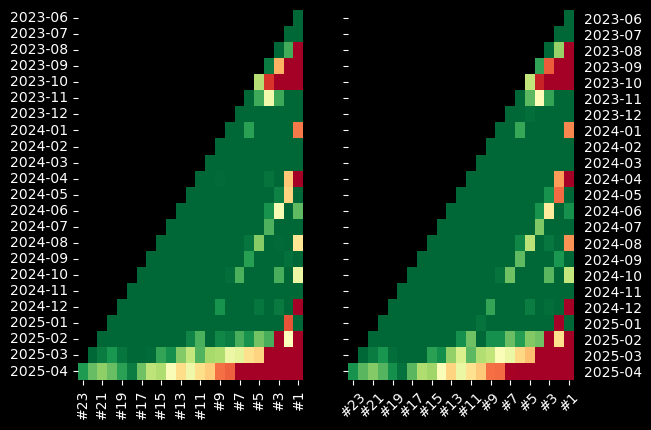

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2)
prices.index = pd.to_datetime(prices.index)
ax={'sharpe': ax1, 'sortino': ax2}
for i, v in ax.items():
    p_tr = prices[i].resample("ME").last()
    p_ret = np.log(p_tr / p_tr.shift()).dropna().to_frame()
    p_ret.columns = ["Return"]
    windows = [year for year in range(p_ret.index.size, 0, -1)]
    for period in windows:
        p_ret["#{}".format(period)] = p_ret.Return.rolling(period).mean()
    triangle = p_ret.drop(columns = ["Return"])
    triangle.index = triangle.index.to_period('M')
    sns.heatmap(triangle, annot=False, cmap="RdYlGn", vmin=-0.2/12, vmax=0.2/12, center=0, cbar=False, ax=v)

# plt.figure(figsize=(80,50))
plt.tick_params(axis = "y", labelright =True, labelleft=False, grid_alpha=.5)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

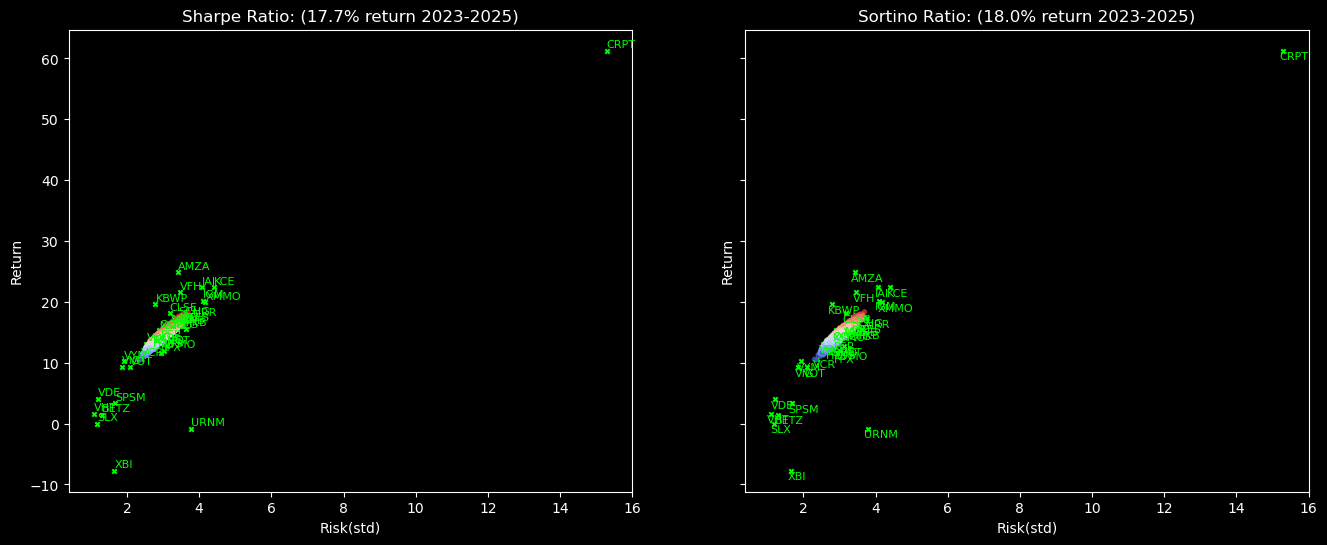

In [27]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(16, 6))
axes[0].scatter(summary.loc[:, "Risk"], summary.loc[:, "Return"]*100, s=10, marker="x", c="lime")
axes[0].scatter(port_summary.loc[:, "Risk"], port_summary.loc[:, "Return"]*100, s=8, c=port_summary.loc[:, "Sharpe"], cmap="coolwarm",
    vmin=port_summary.Sharpe.min(), vmax=port_summary.loc[msrp].Sharpe, alpha=.7)
for i in summary.index:
    axes[0].annotate(i, xy=(summary.loc[i, "Risk"]+0.0002, summary.loc[i, "Return"]*100+.5), size=8, c="lime")

axes[1].scatter(summary.loc[:, "Risk"], summary.loc[:, "Return"]*100, s=10, marker="x", c="lime")
axes[1].scatter(port_summary.loc[:, "Risk"], port_summary.loc[:, "Return"]*100, s=8, c=port_summary.loc[:, "Sortino"], cmap="coolwarm",
    vmin=port_summary.Sortino.min(), vmax=port_summary.loc[msrp1].Sortino, alpha=.7)
for i in summary.index:
    axes[1].annotate(i, xy=(summary.loc[i, "Risk"]-0.1, summary.loc[i, "Return"]*100-1.5), size=8, c="lime")

axes[0].set_xlabel('Risk(std)')
axes[0].set_ylabel('Return')
axes[1].set_xlabel('Risk(std)')
axes[1].set_ylabel('Return')

axes[0].set_title(f"Sharpe Ratio: ({port_summary.loc[msrp].Return*100:.1f}% return {str(start)[:4]}-{end[:4]})")
axes[1].set_title(f"Sortino Ratio: ({port_summary.loc[msrp1].Return*100:.1f}% return {str(start)[:4]}-{end[:4]})")
plt.show()

## Overlaps ##

In [28]:
g = net.Network(notebook=True, bgcolor='#111111', font_color='white', width="100%", height="800px")#, cdn_resources='in_line')
# g.repulsion()
g.physics = "forceAtlas2Based"
# g.inherit_edge_colors(False)
nxg=nx.complete_graph(0)
for n in summary.index: # FIXME: colors of edges
    if summary.loc[n]['category'] == 'INDEX':
        continue
    kw = {'label':n, 'shape':'box'} #'size':abs(summary.loc[n, 'Return'])*100
    kw['title'] = textwrap.fill(funds[n]['summaryProfile'].get('longBusinessSummary', funds[n]['summaryProfile'].get('description')), 60)
    if summary.loc[n, 'Return'] < 0:
        kw['color'] = 'red'
    kw['borderWidth'] = abs(summary.loc[n]['Return']) * 100
    kw['group'] = summary.loc[n]['category']
    nxg.add_node(n, **kw)
    for h in funds[n].get('topHoldings',{}).get('holdings',{}):
        nxg.add_node(h['symbol'], label=h['holdingName'], shape='text')
        nxg.add_edge(n, h['symbol'], value=h['holdingPercent'], title=f"{100*h['holdingPercent']:.1f}%")
g.from_nx(nxg)
g.show("overlaps.html")

overlaps.html


In [29]:
ms = range(20, 101, 10)
dfmd = pd.DataFrame(index = ms, columns=idx['Adj Close'].columns)

for finish in ms:
    n, best = min([3, len(idx['Adj Close'].columns)//2]), {c:0 for c in idx['Adj Close'].columns}
    for v in range(100):
        t0 = int(v * (prices.shape[0] * finish / 100 / 100)) # Starting time for comparison
        df = (prices.iloc[:int((prices.shape[0] * finish / 100))] / prices.iloc[t0]).dropna() # DataFrame normalized against Starting time prices
        if t0 + 1 >= df.shape[0]:
            continue
        ratios = ann_risk_return(df.iloc[int(v * (df.shape[0] / 100)):])['Return'][:-2] * 100
        for x in ratios.nlargest(n).index:
            best[x] = 1 if not x in best else best[x]+1
    summary['Top'] = [best[x] for x in sorted(best)] # Sample 100 intervals' to date for top N returns
    weight = 'weight' if model == 'Sharpe' else 'weight1'
    dfmd.loc[finish] = [best[x] for x in sorted(best)]
    
dfmd.index = [str(prices.iloc[int(prices.shape[0] * x / 100)].name)[:10] for x in range(10, 100, 10)]
px.imshow(dfmd.T, template=template, color_continuous_scale=px.colors.sequential.Viridis, color_continuous_midpoint=55,
          title=f"In Top {n} Performers {dfmd.index[0]} ... {dfmd.index[-1]}")

### Obsolete

---

## Screener

In [ ]:
droplist = " ".join((TEST, " ".join((categories.values()))))
shortlist = []
for r in recommendations.values():
    for v in r.values():
        if v=='No data found':
            continue
        for rec in v['recommendedSymbols']:
            if not (rec['symbol'] in droplist):
                shortlist.append(rec['symbol'])
profiles = {n:Ticker(n).fund_profile[n] for n in shortlist}
for prop in ['maxAge', 'styleBoxUrl']:
    for k,v in profiles.items():
        if prop in v:
            del v[prop]
shortlist = [p for p, v in profiles.items() if 'categoryName' in v and not 'Leveraged' in v['categoryName']]
" ".join(sorted({*shortlist}))

In [ ]:
# Recommendations
g = net.Network(notebook=True, bgcolor='#111111', font_color='white', width="100%", height="800px")#, cdn_resources='in_line')
g.repulsion()
g.physics = "forceAtlas2Based"
nxg=nx.complete_graph(0)
for n in summary.index:
    if n == '^VIX':
        continue
    kw = {'label':n, 'shape':'box'}
    kw['group'] = summary.loc[n]['category']
    kw['title'] = textwrap.fill(funds[n]['summaryProfile'].get('longBusinessSummary', funds[n]['summaryProfile'].get('description')), 60)
    nxg.add_node(n, **kw)
    if list(recommendations[n].values()) == ['No data found']:
        continue
    for h in list(recommendations[n].values())[0]['recommendedSymbols']:
        if not h['symbol'] in shortlist:
            continue
        nxg.add_node(h['symbol'], label=h['symbol'], shape='text', title=json.dumps(profiles[h['symbol']], indent=2))
        nxg.add_edge(n, h['symbol'], value=h['score'], title=100*h['score'])
g.from_nx(nxg)
g.show("recommendations.html")

In [ ]:
s = Screener()
print([x for x in s.available_screeners if 'etf' in x and not 'asia' in x and not 'europe' in x])

In [ ]:
screener = ['fifty_two_wk_losers_etfs', 'cheapest_etfs', 'top_etfs_us'] #'top_performing_etfs', 'precious_metal_etfs'
def g(row):
    return [str(r) for r in row.values]
    
def bold_row(row):
    return ['font-weight: bold' if 'ChangePercent' in row.name else '' for v in row]

def bold_index(s):
    return '<b>{}</b>'.format(s)

def h_hi(row):
    return ['background-color: lightgreen']*len(row.values) if 'ChangePercent' in row.name else ['']*len(row.values)

droprows=["shortName", 'exchange', 'firstTradeDateMilliseconds', 'messageBoardId', 'dividendDate', 'fiftyTwoWeekLowChangePercent',
          'fiftyTwoWeekHighChangePercent', 'fiftyDayAverageChangePercent', 'twoHundredDayAverageChangePercent', 'fiftyTwoWeekLowChange',
          'fiftyTwoWeekHighChange', 'regularMarketChange', 'isEarningsDateEstimate', 'postMarketChangePercent', 'askSize', 'bidSize',
          'ipoExpectedDate', 'epsTrailingTwelveMonths', 'sharesOutstanding', 'bookValue', 'marketCap', 'netAssets']
quotes = [i for q in s.get_screeners(screener, 48).values() for i in q['quotes'] if not i['symbol'] in droplist]
df = pd.json_normalize(quotes).set_index('symbol').T
df.drop(df.index[:7], inplace=True)
df.drop([c for c in df.index if 'Time' in c], inplace=True)
df.dropna(axis=1, subset=['longName'], inplace=True)

regex = re.compile('|'.join(['everage', "Ether", 'Bitcoin', 'Bond', "Ultra", "Short", "Long", 'Hedge', 'Option', 'Covered Call', 'Treasury',
                             "Trust", "Daily", "Monthly", 'Weekly', 'Asia', 'China', 'Emerging', 'iShares MSCI']))
df.drop(columns=df.columns[df.loc['longName'].str.contains(regex)], axis=1, inplace=True)

for i in df.index:
    if 1 == len(set(g(df.loc[i,:]))):
        droprows.append(i)
df.drop(droprows, inplace=True, errors='ignore')
df = df.sort_values(by=['fiftyTwoWeekChangePercent'], axis=1, ascending=False)
df = df.fillna('')

df.drop(droplist, axis=1, errors='ignore', inplace=True)
df.head(60).style.apply(h_max, axis=1).apply(h_min, axis=1).apply(bold_row, axis=1).apply(h_hi, axis=1)

In [ ]:
" ".join(df.columns)

## Algo Return

In [ ]:
algo=(1 + idx['Adj Close'].pct_change() * idx['position_ema'].shift(1)).cumprod()
px.line(algo, template=template, log_y=True, title="Algo EMA")

In [ ]:
algo=(1 + idx['Adj Close'].pct_change() * idx['position_rsi'].shift(1)).cumprod()
px.line(algo, template=template, log_y=True, title="Algo RSI")

In [ ]:
# def calc_positions_ichimoku(d):
#     global idx
#     columns = d['Low'].columns
#     condition = np.where(
#         # (d['Close'] > d['tenkan_sen']) & (d['tenkan_sen'] > d['kijun_sen']) &
#         ((d['Close'] > d['tenkan_sen']) & (d['Close'] > d['kijun_sen'])) & (d['tenkan_sen'] > d['kijun_sen']) &
#         (
#             ((d['Close'] > d['senkou_span_a']) & (d['Close'] > d['senkou_span_b'])) |
#             ((d['Close'] < d['senkou_span_a']) & (d['Close'] < d['senkou_span_b']) & (d['senkou_span_a'] < d['senkou_span_b']))
#         ), 0, 1
#     )
#     sgn = pd.DataFrame(condition, columns=columns, index=d.index)
#     sgn.columns = pd.MultiIndex.from_product([['signal_ichimoku'], columns])
#     pos = sgn.diff().fillna(0)
#     pos.columns = pd.MultiIndex.from_product([['position_ichimoku'], columns])
#     idx.drop(columns='signal_ichimoku', inplace=True, errors='ignore')
#     idx.drop(columns='position_ichimoku', inplace=True, errors='ignore')
#     idx = idx.join(pos)
#     idx = idx.join(sgn)
# calc_positions_ichimoku(idx)

algo=(1 + idx['Adj Close'].pct_change() * idx['position_ichimoku'].shift(1)).cumprod()
px.line(algo, template=template, log_y=True, title="Algo Ichimoku")

## Timestamp

In [ ]:
datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")